In [1]:
#@title Norm

import torch
import torch.nn as nn


def get_normalization(config, conditional=True):
    norm = config.model.normalization
    if conditional:
        if norm == 'NoneNorm':
            return ConditionalNoneNorm2d
        elif norm == 'InstanceNorm++':
            return ConditionalInstanceNorm2dPlus
        elif norm == 'InstanceNorm':
            return ConditionalInstanceNorm2d
        elif norm == 'BatchNorm':
            return ConditionalBatchNorm2d
        elif norm == 'VarianceNorm':
            return ConditionalVarianceNorm2d
        else:
            raise NotImplementedError("{} does not exist!".format(norm))
    else:
        if norm == 'BatchNorm':
            return nn.BatchNorm2d
        elif norm == 'InstanceNorm':
            return nn.InstanceNorm2d
        elif norm == 'InstanceNorm++':
            return InstanceNorm2dPlus
        elif norm == 'VarianceNorm':
            return VarianceNorm2d
        elif norm == 'NoneNorm':
            return NoneNorm2d
        elif norm is None:
            return None
        else:
            raise NotImplementedError("{} does not exist!".format(norm))

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        if self.bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.bn(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=1)
            out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * out
        return out


class ConditionalInstanceNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        h = self.instance_norm(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=-1)
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out


class ConditionalVarianceNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=False):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.embed = nn.Embedding(num_classes, num_features)
        self.embed.weight.data.normal_(1, 0.02)

    def forward(self, x, y):
        vars = torch.var(x, dim=(2, 3), keepdim=True)
        h = x / torch.sqrt(vars + 1e-5)

        gamma = self.embed(y)
        out = gamma.view(-1, self.num_features, 1, 1) * h
        return out


class VarianceNorm2d(nn.Module):
    def __init__(self, num_features, bias=False):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.alpha = nn.Parameter(torch.zeros(num_features))
        self.alpha.data.normal_(1, 0.02)

    def forward(self, x):
        vars = torch.var(x, dim=(2, 3), keepdim=True)
        h = x / torch.sqrt(vars + 1e-5)

        out = self.alpha.view(-1, self.num_features, 1, 1) * h
        return out


class ConditionalNoneNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=-1)
            out = gamma.view(-1, self.num_features, 1, 1) * x + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * x
        return out


class NoneNorm2d(nn.Module):
    def __init__(self, num_features, bias=True):
        super().__init__()

    def forward(self, x):
        return x


class InstanceNorm2dPlus(nn.Module):
    def __init__(self, num_features, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        self.alpha = nn.Parameter(torch.zeros(num_features))
        self.gamma = nn.Parameter(torch.zeros(num_features))
        self.alpha.data.normal_(1, 0.02)
        self.gamma.data.normal_(1, 0.02)
        if bias:
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            h = h + means[..., None, None] * self.alpha[..., None, None]
            out = self.gamma.view(-1, self.num_features, 1, 1) * h + self.beta.view(-1, self.num_features, 1, 1)
        else:
            h = h + means[..., None, None] * self.alpha[..., None, None]
            out = self.gamma.view(-1, self.num_features, 1, 1) * h
        return out


class ConditionalInstanceNorm2dPlus(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 3)
            self.embed.weight.data[:, :2 * num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, 2 * num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, 2 * num_features)
            self.embed.weight.data.normal_(1, 0.02)

    def forward(self, x, y):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            gamma, alpha, beta = self.embed(y).chunk(3, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma, alpha = self.embed(y).chunk(2, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out

In [2]:
#@title Layers

import torch.nn as nn
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
#from normalization import *
from functools import partial
import math
import torch.nn.init as init


def get_act(config):
    if config.model.nonlinearity.lower() == 'elu':
        return nn.ELU()
    elif config.model.nonlinearity.lower() == 'relu':
        return nn.ReLU()
    elif config.model.nonlinearity.lower() == 'lrelu':
        return nn.LeakyReLU(negative_slope=0.2)
    elif config.model.nonlinearity.lower() == 'swish':
        def swish(x):
            return x * torch.sigmoid(x)
        return swish
    else:
        raise NotImplementedError('activation function does not exist!')

def spectral_norm(layer, n_iters=1):
    return torch.nn.utils.spectral_norm(layer, n_power_iterations=n_iters)

def conv1x1(in_planes, out_planes, stride=1, bias=True, spec_norm=False):
    "1x1 convolution"
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias)
    if spec_norm:
        conv = spectral_norm(conv)
    return conv


def conv3x3(in_planes, out_planes, stride=1, bias=True, spec_norm=False):
    "3x3 convolution with padding"
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=bias)
    if spec_norm:
        conv = spectral_norm(conv)

    return conv


def stride_conv3x3(in_planes, out_planes, kernel_size, bias=True, spec_norm=False):
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=2,
                     padding=kernel_size // 2, bias=bias)
    if spec_norm:
        conv = spectral_norm(conv)
    return conv


def dilated_conv3x3(in_planes, out_planes, dilation, bias=True, spec_norm=False):
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=dilation, dilation=dilation, bias=bias)
    if spec_norm:
        conv = spectral_norm(conv)

    return conv

class CRPBlock(nn.Module):
    def __init__(self, features, n_stages, act=nn.ReLU(), maxpool=True, spec_norm=False):
        super().__init__()
        self.convs = nn.ModuleList()
        for i in range(n_stages):
            self.convs.append(conv3x3(features, features, stride=1, bias=False, spec_norm=spec_norm))
        self.n_stages = n_stages
        if maxpool:
            self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        else:
            self.maxpool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)

        self.act = act

    def forward(self, x):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x


class CondCRPBlock(nn.Module):
    def __init__(self, features, n_stages, num_classes, normalizer, act=nn.ReLU(), spec_norm=False):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.normalizer = normalizer
        for i in range(n_stages):
            self.norms.append(normalizer(features, num_classes, bias=True))
            self.convs.append(conv3x3(features, features, stride=1, bias=False, spec_norm=spec_norm))

        self.n_stages = n_stages
        self.maxpool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x, y):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.norms[i](path, y)
            path = self.maxpool(path)
            path = self.convs[i](path)

            x = path + x
        return x


class RCUBlock(nn.Module):
    def __init__(self, features, n_blocks, n_stages, act=nn.ReLU(), spec_norm=False):
        super().__init__()

        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}_{}_conv'.format(i + 1, j + 1), conv3x3(features, features, stride=1, bias=False,
                                                                         spec_norm=spec_norm))

        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
        self.act = act

    def forward(self, x):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = self.act(x)
                x = getattr(self, '{}_{}_conv'.format(i + 1, j + 1))(x)

            x += residual
        return x


class CondRCUBlock(nn.Module):
    def __init__(self, features, n_blocks, n_stages, num_classes, normalizer, act=nn.ReLU(), spec_norm=False):
        super().__init__()

        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}_{}_norm'.format(i + 1, j + 1), normalizer(features, num_classes, bias=True))
                setattr(self, '{}_{}_conv'.format(i + 1, j + 1),
                        conv3x3(features, features, stride=1, bias=False, spec_norm=spec_norm))

        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
        self.act = act
        self.normalizer = normalizer

    def forward(self, x, y):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = getattr(self, '{}_{}_norm'.format(i + 1, j + 1))(x, y)
                x = self.act(x)
                x = getattr(self, '{}_{}_conv'.format(i + 1, j + 1))(x)

            x += residual
        return x


class MSFBlock(nn.Module):
    def __init__(self, in_planes, features, spec_norm=False):
        """
        :param in_planes: tuples of input planes
        """
        super().__init__()
        assert isinstance(in_planes, list) or isinstance(in_planes, tuple)
        self.convs = nn.ModuleList()
        self.features = features

        for i in range(len(in_planes)):
            self.convs.append(conv3x3(in_planes[i], features, stride=1, bias=True, spec_norm=spec_norm))

    def forward(self, xs, shape):
        sums = torch.zeros(xs[0].shape[0], self.features, *shape, device=xs[0].device)
        for i in range(len(self.convs)):
            h = self.convs[i](xs[i])
            h = F.interpolate(h, size=shape, mode='bilinear', align_corners=True)
            sums += h
        return sums


class CondMSFBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer, spec_norm=False):
        """
        :param in_planes: tuples of input planes
        """
        super().__init__()
        assert isinstance(in_planes, list) or isinstance(in_planes, tuple)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.features = features
        self.normalizer = normalizer

        for i in range(len(in_planes)):
            self.convs.append(conv3x3(in_planes[i], features, stride=1, bias=True, spec_norm=spec_norm))
            self.norms.append(normalizer(in_planes[i], num_classes, bias=True))

    def forward(self, xs, y, shape):
        sums = torch.zeros(xs[0].shape[0], self.features, *shape, device=xs[0].device)
        for i in range(len(self.convs)):
            h = self.norms[i](xs[i], y)
            h = self.convs[i](h)
            h = F.interpolate(h, size=shape, mode='bilinear', align_corners=True)
            sums += h
        return sums


class RefineBlock(nn.Module):
    def __init__(self, in_planes, features, act=nn.ReLU(), start=False, end=False, maxpool=True, spec_norm=False):
        super().__init__()

        assert isinstance(in_planes, tuple) or isinstance(in_planes, list)
        self.n_blocks = n_blocks = len(in_planes)

        self.adapt_convs = nn.ModuleList()
        for i in range(n_blocks):
            self.adapt_convs.append(
                RCUBlock(in_planes[i], 2, 2, act, spec_norm=spec_norm)
            )

        self.output_convs = RCUBlock(features, 3 if end else 1, 2, act, spec_norm=spec_norm)

        if not start:
            self.msf = MSFBlock(in_planes, features, spec_norm=spec_norm)

        self.crp = CRPBlock(features, 2, act, maxpool=maxpool, spec_norm=spec_norm)

    def forward(self, xs, output_shape):
        assert isinstance(xs, tuple) or isinstance(xs, list)
        hs = []
        for i in range(len(xs)):
            h = self.adapt_convs[i](xs[i])
            hs.append(h)

        if self.n_blocks > 1:
            h = self.msf(hs, output_shape)
        else:
            h = hs[0]

        h = self.crp(h)
        h = self.output_convs(h)

        return h



class CondRefineBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer, act=nn.ReLU(), start=False, end=False, spec_norm=False):
        super().__init__()

        assert isinstance(in_planes, tuple) or isinstance(in_planes, list)
        self.n_blocks = n_blocks = len(in_planes)

        self.adapt_convs = nn.ModuleList()
        for i in range(n_blocks):
            self.adapt_convs.append(
                CondRCUBlock(in_planes[i], 2, 2, num_classes, normalizer, act, spec_norm=spec_norm)
            )

        self.output_convs = CondRCUBlock(features, 3 if end else 1, 2, num_classes, normalizer, act, spec_norm=spec_norm)

        if not start:
            self.msf = CondMSFBlock(in_planes, features, num_classes, normalizer, spec_norm=spec_norm)

        self.crp = CondCRPBlock(features, 2, num_classes, normalizer, act, spec_norm=spec_norm)

    def forward(self, xs, y, output_shape):
        assert isinstance(xs, tuple) or isinstance(xs, list)
        hs = []
        for i in range(len(xs)):
            h = self.adapt_convs[i](xs[i], y)
            hs.append(h)

        if self.n_blocks > 1:
            h = self.msf(hs, y, output_shape)
        else:
            h = hs[0]

        h = self.crp(h, y)
        h = self.output_convs(h, y)

        return h


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, adjust_padding=False, spec_norm=False):
        super().__init__()
        if not adjust_padding:
            conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            if spec_norm:
                conv = spectral_norm(conv)
            self.conv = conv
        else:
            conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            if spec_norm:
                conv = spectral_norm(conv)

            self.conv = nn.Sequential(
                nn.ZeroPad2d((1, 0, 1, 0)),
                conv
            )

    def forward(self, inputs):
        output = self.conv(inputs)
        output = sum([output[:, :, ::2, ::2], output[:, :, 1::2, ::2],
                      output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return output

class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, spec_norm=False):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        if spec_norm:
            self.conv = spectral_norm(self.conv)

    def forward(self, inputs):
        output = inputs
        output = sum([output[:, :, ::2, ::2], output[:, :, 1::2, ::2],
                      output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return self.conv(output)


class UpsampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, spec_norm=False):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        if spec_norm:
            self.conv = spectral_norm(self.conv)
        self.pixelshuffle = nn.PixelShuffle(upscale_factor=2)

    def forward(self, inputs):
        output = inputs
        output = torch.cat([output, output, output, output], dim=1)
        output = self.pixelshuffle(output)
        return self.conv(output)


class ConditionalResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, resample=None, act=nn.ELU(),
                 normalization=ConditionalBatchNorm2d, adjust_padding=False, dilation=None, spec_norm=False):
        super().__init__()
        self.non_linearity = act
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.resample = resample
        self.normalization = normalization
        if resample == 'down':
            if dilation is not None:
                self.conv1 = dilated_conv3x3(input_dim, input_dim, dilation=dilation, spec_norm=spec_norm)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = dilated_conv3x3(input_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation, spec_norm=spec_norm)
            else:
                self.conv1 = conv3x3(input_dim, input_dim, spec_norm=spec_norm)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = ConvMeanPool(input_dim, output_dim, 3, adjust_padding=adjust_padding, spec_norm=spec_norm)
                conv_shortcut = partial(ConvMeanPool, kernel_size=1, adjust_padding=adjust_padding, spec_norm=spec_norm)

        elif resample is None:
            if dilation is not None:
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation, spec_norm=spec_norm)
                self.conv1 = dilated_conv3x3(input_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = dilated_conv3x3(output_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
            else:
                conv_shortcut = nn.Conv2d
                self.conv1 = conv3x3(input_dim, output_dim, spec_norm=spec_norm)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = conv3x3(output_dim, output_dim, spec_norm=spec_norm)
        else:
            raise Exception('invalid resample value')

        if output_dim != input_dim or resample is not None:
            self.shortcut = conv_shortcut(input_dim, output_dim)

        self.normalize1 = normalization(input_dim, num_classes)


    def forward(self, x, y):
        output = self.normalize1(x, y)
        output = self.non_linearity(output)
        output = self.conv1(output)
        output = self.normalize2(output, y)
        output = self.non_linearity(output)
        output = self.conv2(output)

        if self.output_dim == self.input_dim and self.resample is None:
            shortcut = x
        else:
            shortcut = self.shortcut(x)

        return shortcut + output


class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, resample=None, act=nn.ELU(),
                 normalization=nn.BatchNorm2d, adjust_padding=False, dilation=None, spec_norm=False):
        super().__init__()
        self.non_linearity = act
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.resample = resample
        self.normalization = normalization
        if resample == 'down':
            if dilation is not None:
                self.conv1 = dilated_conv3x3(input_dim, input_dim, dilation=dilation, spec_norm=spec_norm)
                self.normalize2 = normalization(input_dim)
                self.conv2 = dilated_conv3x3(input_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation, spec_norm=spec_norm)
            else:
                self.conv1 = conv3x3(input_dim, input_dim, spec_norm=spec_norm)
                self.normalize2 = normalization(input_dim)
                self.conv2 = ConvMeanPool(input_dim, output_dim, 3, adjust_padding=adjust_padding, spec_norm=spec_norm)
                conv_shortcut = partial(ConvMeanPool, kernel_size=1, adjust_padding=adjust_padding, spec_norm=spec_norm)

        elif resample is None:
            if dilation is not None:
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation, spec_norm=spec_norm)
                self.conv1 = dilated_conv3x3(input_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
                self.normalize2 = normalization(output_dim)
                self.conv2 = dilated_conv3x3(output_dim, output_dim, dilation=dilation, spec_norm=spec_norm)
            else:
                # conv_shortcut = nn.Conv2d ### Something wierd here.
                conv_shortcut = partial(conv1x1, spec_norm=spec_norm)
                self.conv1 = conv3x3(input_dim, output_dim, spec_norm=spec_norm)
                self.normalize2 = normalization(output_dim)
                self.conv2 = conv3x3(output_dim, output_dim, spec_norm=spec_norm)
        else:
            raise Exception('invalid resample value')

        if output_dim != input_dim or resample is not None:
            self.shortcut = conv_shortcut(input_dim, output_dim)

        self.normalize1 = normalization(input_dim)


    def forward(self, x):
        output = self.normalize1(x)
        output = self.non_linearity(output)
        output = self.conv1(output)
        output = self.normalize2(output)
        output = self.non_linearity(output)
        output = self.conv2(output)

        if self.output_dim == self.input_dim and self.resample is None:
            shortcut = x
        else:
            shortcut = self.shortcut(x)

        return shortcut + output

### Necessaires

In [3]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch
from functools import partial
#from . import get_sigmas
#from layers import *
#from normalization import get_normalization

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title NCSNv2Deeper 

class NCSNv2Deeper(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.logit_transform = config.data.logit_transform
        self.rescaled = config.data.rescaled
        self.norm = get_normalization(config, conditional=False)
        self.ngf = ngf = config.model.ngf
        self.num_classes = config.model.num_classes
        self.act = act = get_act(config)
        self.register_buffer('sigmas', get_sigmas(config))
        self.config = config
        

        self.begin_conv = nn.Conv2d(config.data.channels, ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(ngf, self.num_classes)

        self.end_conv = nn.Conv2d(ngf, config.data.channels, 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm),
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ResidualBlock(self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res4 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=2),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=2)]
        )

        self.res5 = nn.ModuleList([
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=4),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=4)]
        )

        self.refine1 = RefineBlock([4 * self.ngf], 4 * self.ngf, act=act, start=True)
        self.refine2 = RefineBlock([4 * self.ngf, 4 * self.ngf], 2 * self.ngf, act=act)
        self.refine3 = RefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, act=act)
        self.refine4 = RefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, act=act)
        self.refine5 = RefineBlock([self.ngf, self.ngf], self.ngf, act=act, end=True)

    def _compute_cond_module(self, module, x):
        for m in module:
            x = m(x)
        return x

    def forward(self, x, y):
        if not self.logit_transform and not self.rescaled:
            h = 2 * x - 1.
        else:
            h = x

        output = self.begin_conv(h)

        layer1 = self._compute_cond_module(self.res1, output)
        layer2 = self._compute_cond_module(self.res2, layer1)
        layer3 = self._compute_cond_module(self.res3, layer2)
        layer4 = self._compute_cond_module(self.res4, layer3)
        layer5 = self._compute_cond_module(self.res5, layer4)

        ref1 = self.refine1([layer5], layer5.shape[2:])
        ref2 = self.refine2([layer4, ref1], layer4.shape[2:])
        ref3 = self.refine3([layer3, ref2], layer3.shape[2:])
        ref4 = self.refine4([layer2, ref3], layer2.shape[2:])
        output = self.refine5([layer1, ref4], layer1.shape[2:])

        output = self.normalizer(output)
        output = self.act(output)
        output = self.end_conv(output)

        used_sigmas = self.sigmas[y.long()].view(x.shape[0], *([1] * len(x.shape[1:])))

        output = output / used_sigmas

        return output


In [6]:
import yaml

# Load the YAML file as a dictionary
file_path = '/content/drive/MyDrive/Colab Notebooks/configs.yml'  # Replace this with the actual path to your file

with open(file_path, "r") as file:
    config_dict = yaml.safe_load(file)

# Access the elements of the dictionary using dot notation
class Config:
    def __init__(self, d):
        self.training = Config.Training(d["training"])
        self.sampling = Config.Sampling(d["sampling"])
        self.fast_fid = Config.FastFID(d["fast_fid"])
        self.test = Config.Test(d["test"])
        self.data = Config.Data(d["data"])
        self.model = Config.Model(d["model"])
        self.optim = Config.Optim(d["optim"])
    class Training:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.n_epochs = d["n_epochs"]
            self.n_iters = 20
            self.snapshot_freq = d["snapshot_freq"]
            self.snapshot_sampling = d["snapshot_sampling"]
            self.anneal_power = d["anneal_power"]
            self.log_all_sigmas = d["log_all_sigmas"]

    class Sampling:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.data_init = d["data_init"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.ckpt_id = d["ckpt_id"]
            self.final_only = d["final_only"]
            self.fid = d["fid"]
            self.denoise = d["denoise"]
            self.num_samples4fid = d["num_samples4fid"]
            self.inpainting = d["inpainting"]
            self.interpolation = d["interpolation"]
            self.n_interpolations = d["n_interpolations"]

    class FastFID:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.num_samples = d["num_samples"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.verbose = d["verbose"]
            self.ensemble = d["ensemble"]

    class Test:
        def __init__(self, d):
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.batch_size = d["batch_size"]

    class Data:
        def __init__(self, d):
            self.dataset = d["dataset"]
            self.image_size = d["image_size"]
            self.channels = d["channels"]
            self.logit_transform = d["logit_transform"]
            self.uniform_dequantization = d["uniform_dequantization"]
            self.gaussian_dequantization = d["gaussian_dequantization"]
            self.random_flip = d["random_flip"]
            self.rescaled = d["rescaled"]
            self.num_workers = d["num_workers"]

    class Model:
        def __init__(self, d):
            self.sigma_begin = d["sigma_begin"]
            self.num_classes = d["num_classes"]
            self.ema = d["ema"]
            self.ema_rate = d["ema_rate"]
            self.spec_norm = d["spec_norm"]
            self.sigma_dist = d["sigma_dist"]
            self.sigma_end = d["sigma_end"]
            self.normalization = d["normalization"]
            self.nonlinearity = d["nonlinearity"]
            self.ngf = d["ngf"]

    class Optim:
        def __init__(self, d):
            self.weight_decay = d["weight_decay"]
            self.optimizer = d["optimizer"]
            self.lr = d["lr"]
            self.beta1 = d["beta1"]
            self.amsgrad = d["amsgrad"]
            self.eps = d["eps"]

    


# Create a config object
config = Config(config_dict)

In [7]:
def anneal_dsm_score_estimation(scorenet, samples, sigmas, labels=None, anneal_power=2., hook=None):
    if labels is None:
        labels = torch.randint(0, len(sigmas), (samples.shape[0],), device=samples.device)
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    noise = torch.randn_like(samples) * used_sigmas
    perturbed_samples = samples + noise
    target = - 1 / (used_sigmas ** 2) * noise
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    if hook is not None:
        hook(loss, labels)

    return loss.mean(dim=0)

In [8]:
#@title SVHN
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

100%|██████████| 182040794/182040794 [00:18<00:00, 10035521.65it/s]


100%|██████████| 64275384/64275384 [00:07<00:00, 9140046.59it/s] 


In [20]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
subset_size = 60000  # The number of samples you want in the subset
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
svhn_train_subset = Subset(train_dataset, indices)

dataloader = DataLoader(svhn_train_subset, batch_size=128, shuffle=True, num_workers=4)

In [21]:
def get_sigmas(config):
    if config.model.sigma_dist == 'geometric':
        sigmas = torch.tensor(
            np.exp(np.linspace(np.log(config.model.sigma_begin), np.log(config.model.sigma_end),
                               config.model.num_classes))).float().to(device)
    elif config.model.sigma_dist == 'uniform':
        sigmas = torch.tensor(
            np.linspace(config.model.sigma_begin, config.model.sigma_end, config.model.num_classes)
        ).float()#.to(config.device)

    else:
        raise NotImplementedError('sigma distribution not supported')

    return sigmas

In [22]:
import torch
from torch.optim import Adam

# Instantiate the model
model = NCSNv2Deeper(config)

# Move the model to the desired device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the optimizer
optimizer = Adam(model.parameters(), lr=config.optim.lr)

# Define the number of training epochs
n_epochs = 30

# Define the sigmas
sigmas = get_sigmas(config)

In [16]:
#@title earlyStoping 

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [17]:
early_stopping = EarlyStopping(patience=20, verbose=True)


In [23]:
# Training loop
for epoch in range(n_epochs):
    for batch_idx, (data, labels) in enumerate(dataloader):
        # Move data and labels to the desired device
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass: compute the scores from the model
        optimizer.zero_grad()
        loss = anneal_dsm_score_estimation(model, data, sigmas, labels, anneal_power=config.training.anneal_power)

        # Backward pass: compute the gradient of the loss with respect to the model's parameters
        loss.backward()

        # Update the model's parameters
        optimizer.step()

        # Print the current training progress
        print(f"Epoch: {epoch + 1}/{n_epochs}, Batch: {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item()}")

        # Update the early stopping object with the current validation loss and model
        early_stopping(loss.item(), model)

        if early_stopping.early_stop:
          print("Early stopping")
          break

# Save the trained model
torch.save(model.state_dict(), "trained_model3.pth")

Epoch: 1/30, Batch: 1/469, Loss: 1937.50537109375
Validation loss decreased (2215.172119 --> 1937.505371). Saving model ...
Epoch: 1/30, Batch: 2/469, Loss: 3143.12548828125
EarlyStopping counter: 1 out of 20
Epoch: 1/30, Batch: 3/469, Loss: 1552.60302734375
Validation loss decreased (1937.505371 --> 1552.603027). Saving model ...
Epoch: 1/30, Batch: 4/469, Loss: 1207.692138671875
Validation loss decreased (1552.603027 --> 1207.692139). Saving model ...
Epoch: 1/30, Batch: 5/469, Loss: 1241.1109619140625
EarlyStopping counter: 1 out of 20
Epoch: 1/30, Batch: 6/469, Loss: 1149.3233642578125
Validation loss decreased (1207.692139 --> 1149.323364). Saving model ...
Epoch: 1/30, Batch: 7/469, Loss: 939.6043701171875
Validation loss decreased (1149.323364 --> 939.604370). Saving model ...
Epoch: 1/30, Batch: 8/469, Loss: 729.9440307617188
Validation loss decreased (939.604370 --> 729.944031). Saving model ...
Epoch: 1/30, Batch: 9/469, Loss: 606.3427734375
Validation loss decreased (729.944

### Sampling

In [14]:
#@title Set up the SDE
import functools

from functools import partial, reduce


device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  10.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [24]:
def anneal_Langevin_dynamics(x_mod, scorenet, sigmas, n_steps_each=3, step_lr=0.000008,
                             final_only=False, verbose=False, denoise=True):
    images = []

    with torch.no_grad():
        for c, sigma in enumerate(sigmas):
            labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
            labels = labels.long()
            step_size = step_lr * (sigma / sigmas[-1]) ** 2
            for s in range(n_steps_each):
                grad = scorenet(x_mod, labels)

                noise = torch.randn_like(x_mod)
                grad_norm = torch.norm(grad.view(grad.shape[0], -1), dim=-1).mean()
                noise_norm = torch.norm(noise.view(noise.shape[0], -1), dim=-1).mean()
                x_mod = x_mod + step_size * grad + noise * np.sqrt(step_size * 2)
                    
                image_norm = torch.norm(x_mod.view(x_mod.shape[0], -1), dim=-1).mean()
                snr = np.sqrt(step_size / 2.) * grad_norm / noise_norm
                grad_mean_norm = torch.norm(grad.mean(dim=0).view(-1)) ** 2 * sigma ** 2

                if not final_only:
                    images.append(x_mod.to('gpu'))
                if verbose:
                    print("level: {}, step_size: {}, grad_norm: {}, image_norm: {}, snr: {}, grad_mean_norm: {}".format(
                        c, step_size, grad_norm.item(), image_norm.item(), snr.item(), grad_mean_norm.item()))

        if denoise:
            last_noise = (len(sigmas) - 1) * torch.ones(x_mod.shape[0], device=x_mod.device)
            last_noise = last_noise.long()
            x_mod = x_mod + sigmas[-1] ** 2 * scorenet(x_mod, last_noise)
            images.append(x_mod.to('cpu'))

        if final_only:
            return [x_mod.to('cpu')]
        else:
            return images

In [25]:
def logit_transform(image, lam=1e-6):
    image = lam + (1 - 2 * lam) * image
    return torch.log(image) - torch.log1p(-image)

In [26]:
## Random state will be affected because of sampling during training time.
init_samples = torch.rand(36, 3,
                          32, 32,
                          device=device)



In [27]:
init_samples = logit_transform(init_samples, lam=1e-6)

In [29]:
ema_helper = EMAHelper(mu=0.999)


In [30]:
score = NCSNv2Deeper

In [ ]:
#test_score = ema_helper.ema_copy(score)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/trained_model.pth', map_location=device)
model.load_state_dict(ckpt)




<All keys matched successfully>

In [32]:
ckpt = torch.load('trained_model3.pth', map_location=device)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [33]:
all_samples = anneal_Langevin_dynamics(init_samples,model, sigmas.cpu(),5,0.062,final_only=True, verbose=True,denoise=True)



level: 0, step_size: 1550000.0, grad_norm: 0.3091965317726135, image_norm: 489168.65625, snr: 4.913206577301025, grad_mean_norm: 33.438358306884766
level: 0, step_size: 1550000.0, grad_norm: 1.0491582155227661, image_norm: 1144307.625, snr: 16.679920196533203, grad_mean_norm: 330.4748229980469
level: 0, step_size: 1550000.0, grad_norm: 1.0561769008636475, image_norm: 510611.21875, snr: 16.829429626464844, grad_mean_norm: 295.87481689453125
level: 0, step_size: 1550000.0, grad_norm: 1.1023286581039429, image_norm: 1204225.5, snr: 17.512237548828125, grad_mean_norm: 264.3811950683594
level: 0, step_size: 1550000.0, grad_norm: 1.105554223060608, image_norm: 525904.375, snr: 17.593626022338867, grad_mean_norm: 249.41253662109375
level: 1, step_size: 1439812.625, grad_norm: 1.1647909879684448, image_norm: 1156481.0, snr: 17.88169288635254, grad_mean_norm: 225.32437133789062
level: 1, step_size: 1439812.625, grad_norm: 1.1721445322036743, image_norm: 545149.25, snr: 17.952035903930664, grad_

In [34]:
sample = all_samples[-1].view(all_samples[-1].shape[0],3,
                                                      32,
                                                      32)

In [35]:
def inverse_data_transform(config, X):
    if hasattr(config, 'image_mean'):
        X = X + config.image_mean.to(X.device)[None, ...]

    if config.data.logit_transform:
        X = torch.sigmoid(X)
    elif config.data.rescaled:
        X = (X + 1.) / 2.

    return torch.clamp(X, 0.0, 1.0)

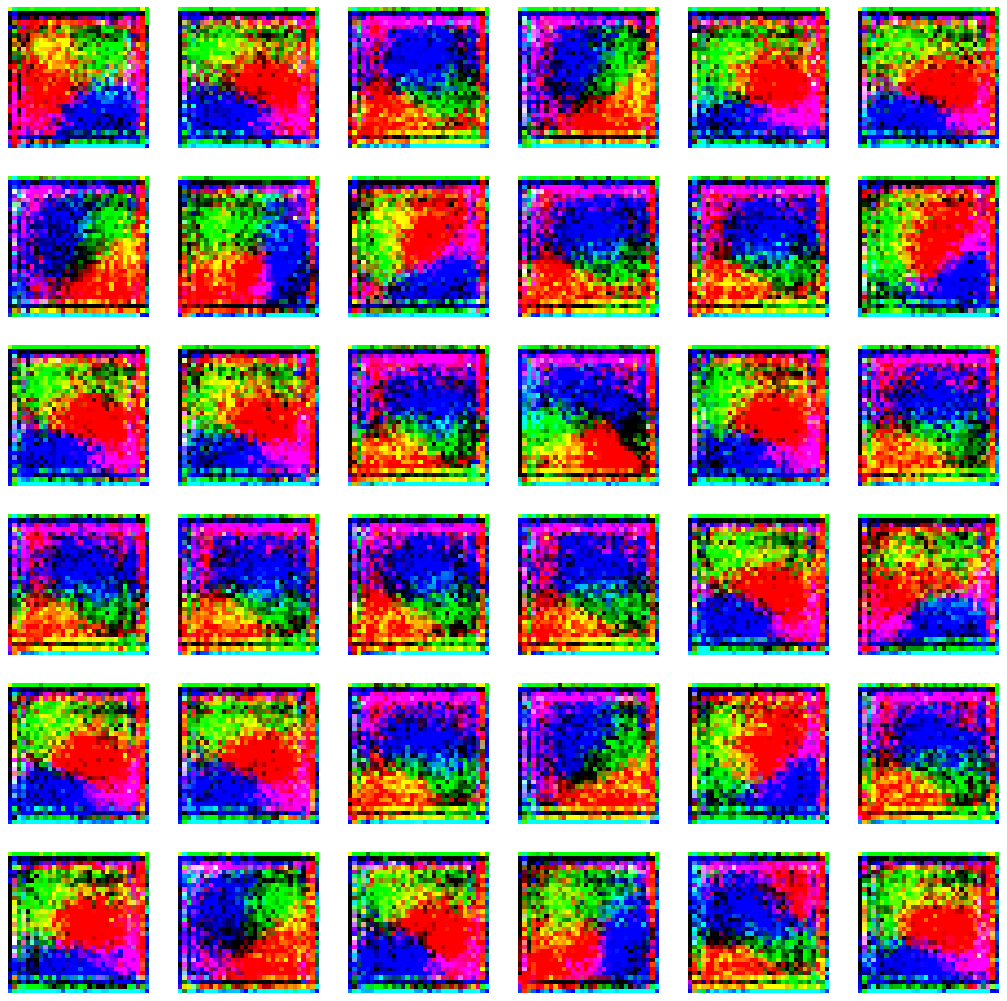

In [36]:
import matplotlib.pyplot as plt


def display_images(images):
    n = int(np.sqrt(images.shape[0]))
    fig, axes = plt.subplots(n, n, figsize=(16, 16), dpi=80)

    for i in range(n):
        for j in range(n):
            img = images[i * n + j].permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

    plt.show()

samples = all_samples[-1].view(all_samples[-1].shape[0], 3, 32, 32)
samples = inverse_data_transform(config, samples)
display_images(samples)

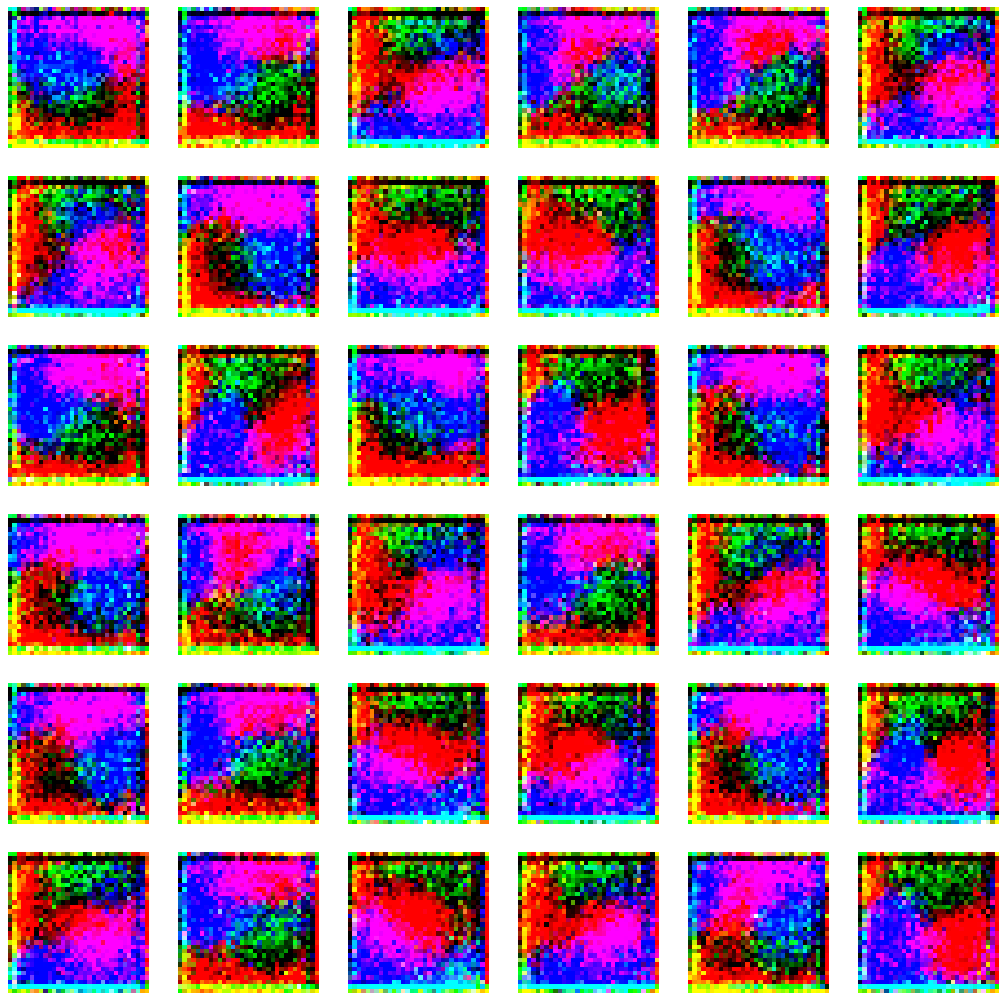

In [182]:
import matplotlib.pyplot as plt


def display_images(images):
    n = int(np.sqrt(images.shape[0]))
    fig, axes = plt.subplots(n, n, figsize=(16, 16), dpi=80)

    for i in range(n):
        for j in range(n):
            img = images[i * n + j].permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

    plt.show()

samples = all_samples[-1].view(all_samples[-1].shape[0], 3, 32, 32)
samples = inverse_data_transform(config, samples)
display_images(samples)

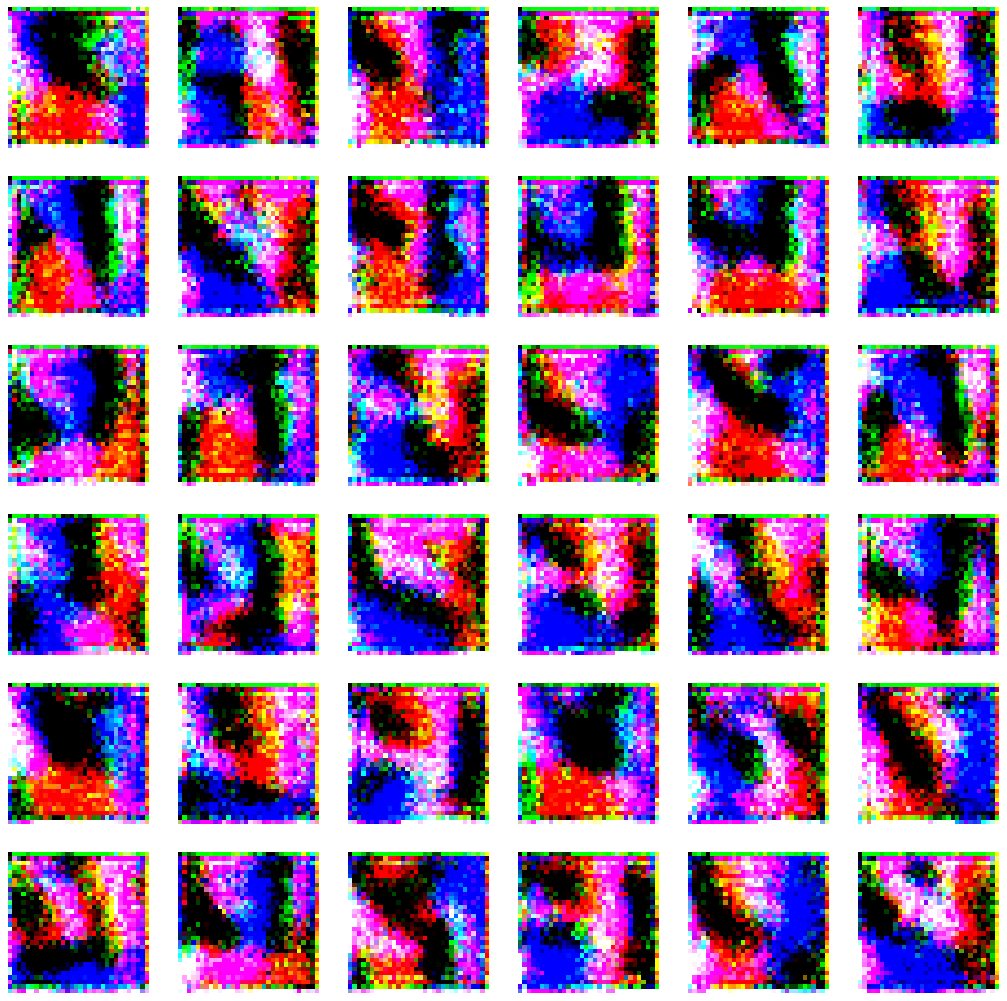

In [163]:
import matplotlib.pyplot as plt


def display_images(images):
    n = int(np.sqrt(images.shape[0]))
    fig, axes = plt.subplots(n, n, figsize=(16, 16), dpi=80)

    for i in range(n):
        for j in range(n):
            img = images[i * n + j].permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

    plt.show()

samples = all_samples[-1].view(all_samples[-1].shape[0], 3, 32, 32)
samples = inverse_data_transform(config, samples)
display_images(samples)

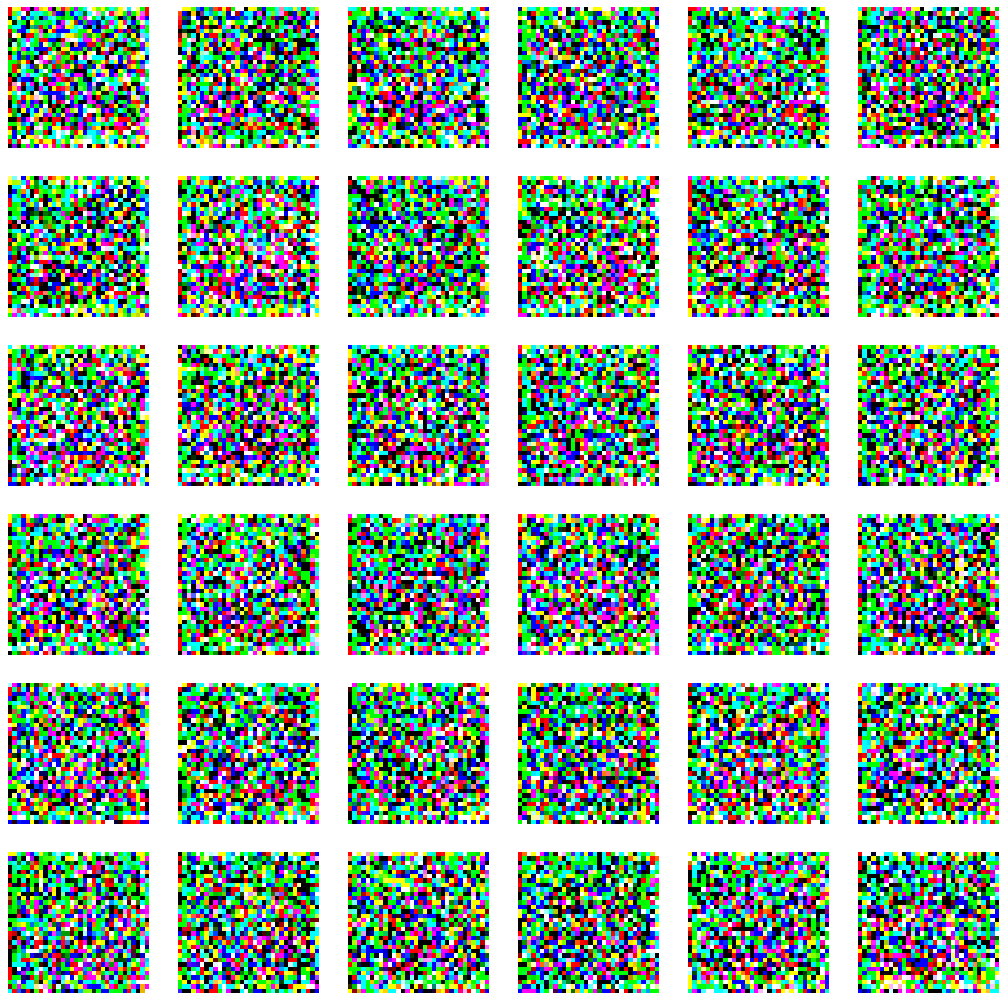

In [ ]:
import matplotlib.pyplot as plt


def display_images(images):
    n = int(np.sqrt(images.shape[0]))
    fig, axes = plt.subplots(n, n, figsize=(16, 16), dpi=80)

    for i in range(n):
        for j in range(n):
            img = images[i * n + j].permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

    plt.show()

samples = all_samples[-1].view(all_samples[-1].shape[0], 3, 32, 32)
samples = inverse_data_transform(config, samples)
display_images(samples)


In [28]:
class EMAHelper(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        if isinstance(module, nn.DataParallel):
            inner_module = module.module
            module_copy = type(inner_module)(inner_module.config).to(inner_module.config.device)
            module_copy.load_state_dict(inner_module.state_dict())
            module_copy = nn.DataParallel(module_copy)
        else:
            module_copy = type(module)(module.config).to(module.config.device)
            module_copy.load_state_dict(module.state_dict())
        # module_copy = copy.deepcopy(module)
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict